In [1]:
from pathlib import Path

import numpy as np
import cv2
import sklearn.cluster
import matplotlib.pyplot as plt
import skimage
import pyefd

from seed_detector.tools import resample_polygon, polygon_area, get_contours as _get_contours

In [2]:
def get_contour(image, n = 200):
    bg_col = (0, 0, 0)
    bin_image = (image != bg_col).all(axis=2)

    contours, hierarchy = cv2.findContours(
        bin_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )
    contours = [c[:, -1, [1, 0]] for c in contours]
    contour = contours[0]
    contour = resample_polygon(contour, n)
    
    return contour

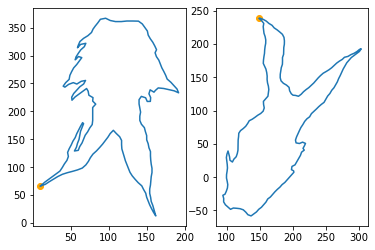

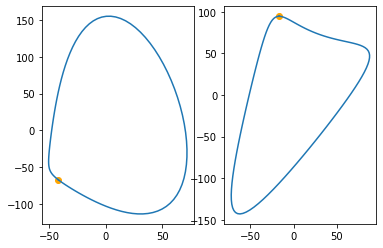

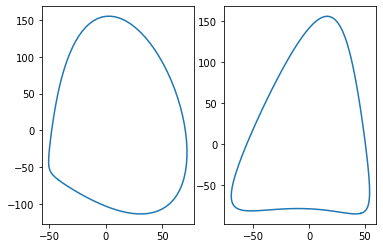

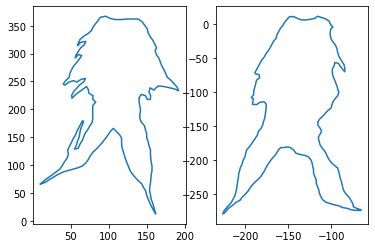

In [51]:
image_path1 = Path('./test/extractions/Scannen1140_bbox4.png')
image1 = cv2.cvtColor(cv2.imread(str(image_path1)), cv2.COLOR_BGR2RGB)
contour1 = get_contour(image1)

image_path2 = Path('./test/extractions/Scannen1140_bbox9.png')
image2 = cv2.cvtColor(cv2.imread(str(image_path2)), cv2.COLOR_BGR2RGB)
contour2 = get_contour(image2)
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
contour2 = contour2.dot(R)


fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
axs[0].scatter(contour1[0, 0], contour1[0, 1], color='orange')
axs[1].plot(contour2[:, 0], contour2[:, 1])
axs[1].scatter(contour2[0, 0], contour2[0, 1], color='orange')

 
contour1_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour1, order=2, normalize=False), num_points=100)
contour2_approx = pyefd.reconstruct_contour(pyefd.elliptic_fourier_descriptors(contour2, order=2, normalize=False), num_points=100)

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx[:, 0], contour1_approx[:, 1])
axs[0].scatter(contour1_approx[0, 0], contour1_approx[0, 1], color='orange')
axs[1].plot(contour2_approx[:, 0], contour2_approx[:, 1])
axs[1].scatter(contour2_approx[0, 0], contour2_approx[0, 1], color='orange')


# rotation, scale = orthogonal_procrustes(contour1_approx, contour2_approx)

# contour1_rot = contour1_approx.copy()
# contour2_rot = contour2_approx.dot(rotation.T)
# disparity = np.sum(np.square(contour1_rot - contour2_rot))


_, best_i, rotation, scale, _ = match_shapes(contour1_approx, contour2_approx)

contour1_approx_rot = contour1_approx.copy()
contour2_approx_rot = contour2_approx.dot(rotation.T)
disparity = np.sum(np.square(contour1_approx_rot - contour2_approx_rot))

fig, axs = plt.subplots(1,2)
axs[0].plot(contour1_approx_rot[:, 0], contour1_approx_rot[:, 1])
axs[1].plot(contour2_approx_rot[:, 0], contour2_approx_rot[:, 1])


fig, axs = plt.subplots(1,2)
axs[0].plot(contour1[:, 0], contour1[:, 1])
contour2_rot = contour2.dot(rotation.T)
axs[1].plot(contour2_rot[:, 0], contour2_rot[:, 1])

In [44]:
from scipy.linalg import orthogonal_procrustes

def match_shapes(a, b):

    a = np.array(a, dtype=np.double, copy=True)
    b = np.array(b, dtype=np.double, copy=True)
    
    a -= np.mean(a, 0)
    b -= np.mean(b, 0)

    norm1 = np.linalg.norm(a)
    norm2 = np.linalg.norm(b)
    
    a /= norm1
    b /= norm2
    
    best_rotation, best_scale = orthogonal_procrustes(a, b)
    best_disparity = np.sum(np.square(a - b.dot(best_rotation.T)))
    best_i = 0
    for i in range(1, b.shape[0]):
        cur_b = np.r_[b[i:,], b[:i,]]
        
        rot, scale = orthogonal_procrustes(a, cur_b)
        disparity = np.sum(np.square(a - cur_b.dot(rot.T)))
        # disparity = np.sum(np.abs(a - cur_b.dot(rot.T)))
        
        # print(i, disparity, best_disparity)
        
        if disparity < best_disparity:
            best_disparity = disparity
            best_rotation = rot
            best_scale = scale
            best_i = i
        
    return b.dot(best_rotation.T), best_i, best_rotation, best_scale, best_disparity

In [45]:
r = match_shapes(contour1_approx, np.r_[contour2_approx[5:,], contour2_approx[:5,]])

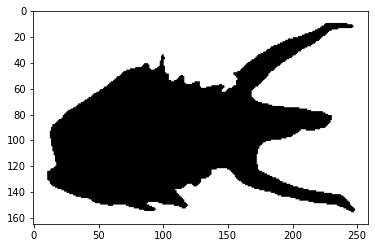

In [76]:
image_path = Path('./test/extractions/Scannen1140_bbox3.png')
image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)

bg_col = (0, 0, 0)
bin_image = (image != bg_col).all(axis=2)
plt.imshow(bin_image, cmap='binary')

contours, hierarchy = cv2.findContours(
    bin_image.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
)
contours = [c[:, -1, [1, 0]] for c in contours]
# contour_sizes = [polygon_area(c) for c in contours]
# contour = contours[np.argsort(contour_sizes)[-1]]
contour = contours[0]
contour = resample_polygon(contour, 200)

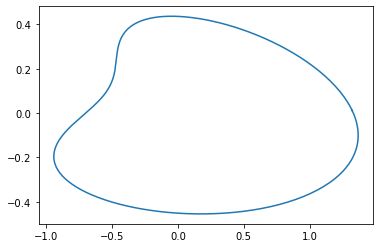

In [75]:
coeffs = pyefd.elliptic_fourier_descriptors(contour, order=2, normalize=True)
contour_rec = pyefd.reconstruct_contour(coeffs)
plt.plot(contour_rec[:, 0], contour_rec[:, 1])

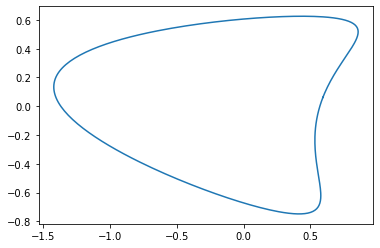

In [78]:
coeffs = pyefd.elliptic_fourier_descriptors(contour, order=2, normalize=True)
contour_rec = pyefd.reconstruct_contour(coeffs)
plt.plot(contour_rec[:, 0], contour_rec[:, 1])

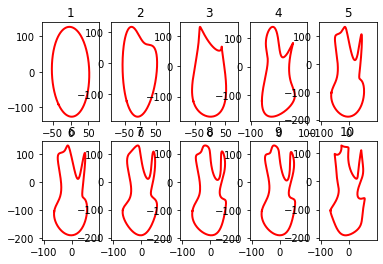

In [56]:
pyefd.plot_efd(pyefd.elliptic_fourier_descriptors(contour, normalize=False))

In [ ]:
image_paths = [*Path('./test/extractions/').glob('Scannen0876_bbox*.png')]

bg_col = (0, 0, 0)
pixel_values = []
for image_path in image_paths:
    image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)

    bg = (image == bg_col).all(axis=2)
    image_values = image[~bg]
    
    pixel_values.extend(image_values)

pixel_values = np.array(pixel_values)

centers, cl, _ = sklearn.cluster.k_means(image_values, n_clusters=4)
x, y = np.unique(cl, return_counts=True)
y = y / y.sum()
order = np.argsort(y)
plt.bar(np.arange(len(x)), y[order], color=centers[order] / 255)

In [ ]:
image_path = Path('./test/extractions/Scannen0001_bbox21.png')

image = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2RGB)

bg = (image == (0, 0, 0)).all(axis=2)
image_values = image[~bg]
# image_values = skimage.color.rgb2lab(image_values)

centers, cl, _ = sklearn.cluster.k_means(image_values, n_clusters=4)
# centers = skimage.color.lab2rgb(centers) * 255

image_new = np.zeros_like(image)
image_new[~bg] = centers[cl]

fig, axs = plt.subplots(1, 2, figsize=(9,5))
axs = axs.flatten()
axs[0].imshow(image_new)

x, y = np.unique(cl, return_counts=True)
y = y / y.sum()
order = np.argsort(y)
axs[1].bar(np.arange(len(x)), y[order], color=centers[order] / 255)